# Dependances

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from pulp import *
from numba import njit
import networkx as nx

def time_to_min(time_str):
    hours, minutes = map(int, time_str.split(':'))
    total_seconds = hours * 60 + minutes
    return total_seconds

def min_to_time(minutes):
    minutes=minutes%1440
    hours = minutes // 60
    minutes = minutes % 60
    time_str = '{:02d}:{:02d}'.format(hours, minutes)
    return time_str


def calculate_pij(demands,chargers,tho):
        n,c=len(demands),len(chargers)
        p=np.zeros((n,c),dtype=np.int16)
        for i in range(n):
            for j in range(c):
                p[i,j]=ceil(demands[i][2]/((tho/60)*chargers[j]))
        return p


def calculate_carecs(Instance):
    
    demands = Instance["demands"]
    chargers = np.array(Instance["chargers"])
    C = Instance["C"]
    tho = Instance["tho"]

    n = len(demands)
    c = len(chargers)
    p = calculate_pij(demands,chargers,tho)
    m = np.min([time_to_min(demand[0]) for demand in demands])
    demands_temp = np.array([(int((time_to_min(demand[0])-m)/tho)+1,int((time_to_min(demand[1])-m)/tho),demand[2]) for demand in demands])
    T = np.max(np.array([demand[1] for demand in demands_temp]))
    return demands,chargers,demands_temp,n,T,c,C,p,m,tho


def simulate_instance(n=20, 
                      min_arrival="6:00",
                      min_availability="3:00",
                      max_arrival="15:00",
                      min_required_energy=30,
                      step=10,
                      max_required_energy=200,
                      chargers=[20,40,50],
                      C=[np.inf,np.inf,np.inf],
                      tho=60):

    min_arrival = time_to_min(min_arrival)
    max_arrival = time_to_min(max_arrival)
    min_availability = time_to_min(min_availability)
    demands = np.empty(n,dtype=object)
    for i in range(n):
        arrival = np.random.choice(range(min_arrival,max_arrival-min_availability+1,tho))
        departure = np.random.choice(range(arrival+min_availability,max_arrival+1,tho))
        required_energy = np.random.choice(range(min_required_energy,max_required_energy+1,step))
        demands[i] = (min_to_time(arrival),min_to_time(departure),required_energy)

    
    Instance={
        "demands":demands,
        "chargers":chargers,
        "C":np.array(C),
        "tho":tho
    }
    return Instance

def plot_schedule(X,Instance, figsize = (15,7)):
    demands,chargers,demands_temp,n,T,c,C,p,m,tho=calculate_carecs(Instance)
    figure = plt.figure(figsize=figsize)
    xticks=[]
    yticks=[]
    for i in range(n):
        yticks+=["$EV_{"+str(i+1)+"}$"+f"       \n{demands[i][2]} kWh"]
        disponibility=range(demands_temp[i][0]-1,demands_temp[i][1])
        plt.plot(disponibility,i*np.ones(len(disponibility)),'blue',linewidth=1.5)
        for t in disponibility:
            if X[i,t]==0:
                plt.plot(t,i,c='blue',marker='.',markersize=25)
            else:
                plt.plot(t,i,c='red',marker='.',markersize=25)
            plt.text(t-ceil(len(str(X[i,t]))/2)/8,i+0.2,s=X[i,t])
            
    for t in range(T):
        xticks.append(min_to_time(m+t*tho)+"\n"+min_to_time(m+(t+1)*tho))
    plt.xlim(-0.3,T)
    plt.ylim(-0.5,n+0.5)
    plt.xticks(range(T),xticks,rotation=40,fontsize=10)
    plt.yticks(range(n),yticks,fontsize=10)
    plt.title("Optimal charging scheduling with $w_{G}=$"+str(np.max(np.sum(X,axis=0)))+" kWh")
    plt.grid()
    plt.show()
    return figure


def exact_solution(Instance, timelimit):
    demands, chargers, demands_temp, n, T, c, C, p, m, tho = calculate_carecs(Instance)
    
    P = LpProblem("P", sense=LpMinimize)
    
    w_G = LpVariable("w_G", lowBound=0, cat="Continuous")
    Y = np.array([[LpVariable(f"Y_{i+1}_{j+1}", lowBound=0, upBound=1, cat="Integer") for j in range(c)] for i in range(n)], dtype=object)
    Zs = np.array([[LpVariable(f"Zs_{i+1}_{t+1}", lowBound=0, upBound=1, cat="Integer") for t in range(T)] for i in range(n)], dtype=object)
    Ze = np.array([[[LpVariable(f"Ze_{i+1}_{t+1},{j+1}", lowBound=0, upBound=1, cat="Integer") for j in range(c)] for t in range(T)] for i in range(n)], dtype=object)
    W = np.array([[[LpVariable(f"W_{i+1}_{t+1}_{j+1}", lowBound=0, upBound=1, cat="Integer") for j in range(c)] for t in range(T)] for i in range(n)], dtype=object)
    ts = np.array([LpVariable(f"ts_{i+1}", lowBound=demands_temp[i, 0], upBound=demands_temp[i, 1], cat="Integer") for i in range(n)], dtype=object)
    
    P += w_G

    for i in range(n):
        P += ts[i] + lpSum(p[i, :] * Y[i, :]) - 1 <= demands_temp[i][1]
        P += lpSum(Y[i, :]) == 1
        for t in range(T):
            if i == 0:
                P += lpSum([chargers[j] * W[i, t, j] for i in range(n) for j in range(c)]) <= w_G
            P += (t + 1) - ts[i] + 1 <= T * Zs[i, t]
            P += ts[i] - (t + 1) <= T * (1 - Zs[i, t])
            for j in range(c):
                P += Y[i, j] + Zs[i, t] + Ze[i, t, j] - 2 <= W[i, t, j]
                P += W[i, t, j] <= Y[i, j]
                P += W[i, t, j] <= Zs[i, t]
                P += W[i, t, j] <= Ze[i, t, j]
                P += ts[i] + p[i, j] * Y[i, j] - (t + 1) <= T * Ze[i, t, j]
                P += (t + 1) - ts[i] - p[i, j] + 1 <= T * (1 - Ze[i, t, j])
                if (i, t) == (0, 0):
                    P += lpSum(Y[:, j]) <= C[j]

    solver = CPLEX_CMD(path=r'C:\Program Files\IBM\ILOG\CPLEX_Studio221\cplex\bin\x64_win64\cplex.exe', timeLimit = timelimit) # Set this to your CPLEX solver path
    P.solve(solver)

    if P.status == 1:
        ts = np.array([ts[i].value() for i in range(n)], dtype=np.int64)
        X = np.zeros((n, T), dtype=np.int64)
        for i in range(n):
            for j in range(c):
                if Y[i, j].value() == 1:
                    X[i, (ts[i] - 1):(ts[i] + p[i, j] - 1)] = chargers[j]
                    break
        best_objective = w_G.value()
    else:
        X = None
        best_objective = None
    
    result = {
        "status": P.status,
        "best_solution": X,
        "best_objective": best_objective
    }
    return result


@njit
def f(X):
    return np.max(np.sum(X,axis=0))

@njit
def assigned_charger(i,X,chargers):
    for cell in X[i,:]:
        if cell!=0:
            for j,charger in enumerate(chargers):
                if cell == charger:
                    return j,charger
                    
def BFS(G,s,p,num_paths):
    Q=[[s]]
    visited=[]
    choosen_paths = []
    while Q:
        actual_path = Q.pop(0)
        if actual_path[-1]==p:
            choosen_paths += [actual_path]
            if len(choosen_paths) == num_paths:
                break
        else:
            candidates = [node for node in G[actual_path[-1]] if node not in visited]
            for node in candidates:
                Q.append(actual_path+[node])
                if node != p:
                    visited.append(node)
    return choosen_paths

def change_charger(EV_index,X,chargers,demands_temp,p,C):
    n,c,X=len(demands_temp),len(chargers),X.copy()
    G = {"p":[]}
    EV_charger = assigned_charger(EV_index,X,chargers)[0]
    for j in range(c):
        G[f"C_{j+1}"]=[]
        if j==EV_charger:
            G[f"C_{j+1}"] += ["p"]
        else:
            if len([i for i in range(n) if assigned_charger(i,X,chargers)[0] == j])==0:
                G[f"C_{j+1}"] += ["p"]
            elif len([i for i in range(n) if assigned_charger(i,X,chargers)[0] == j])<C[j]:
                G[f"C_{j+1}"] += ["p"]
                G["p"] += [f"C_{j+1}"]
            else:
                G["p"] += [f"C_{j+1}"]   
    for i in range(n):
        G[f"v_{i+1}"]=[]
        actual_charger_index, charger = assigned_charger(i,X,chargers)
        for j in range(c):  
            if j == actual_charger_index and i!=EV_index:
                G[f"C_{j+1}"] += [f"v_{i+1}"]
            if j != actual_charger_index and p[i,j]<=demands_temp[i,1]-demands_temp[i,0]+1:
                G[f"v_{i+1}"] += [f"C_{j+1}"]
    choosen_paths = BFS(G,f"v_{EV_index+1}","p", len(chargers))
    direct_paths = [path for path in choosen_paths if len(path)==3]
    if len(direct_paths)>0:
        path_index = np.random.randint(len(direct_paths))
        path = direct_paths[path_index]
    else:
        path_index = np.random.randint(len(choosen_paths))
        path = choosen_paths[path_index]
    path.pop()
    for k in range(0,len(path),2):
        i= int(path[k][2:])-1
        j = int(path[k+1][2:])-1
        t = np.random.randint(demands_temp[i,0] - 1, demands_temp[i,1] - p[i,j] + 1)
        X[i,:] = 0
        X[i, t:t+p[i,j]] = chargers[j]
    return X

@njit
def local_search(X, demands_temp, p, initial_temperature=200, cooling_factor=0.95, stopping_temperature=1e-10):
    n, T = X.shape
    current_X = X.copy()
    current_objective = f(current_X)
    best_X = current_X.copy()
    best_objective = current_objective
    temperature = initial_temperature

    while temperature > stopping_temperature:
        temp_X = current_X.copy()
        
        while True:
            i = np.random.randint(0, n)
            charging_time_indices = np.array([t for t in range(demands_temp[i][0] - 1, demands_temp[i][1]) if temp_X[i, t] != 0])
            t1, t2 = np.min(charging_time_indices), np.max(charging_time_indices)
            
            if t1 > demands_temp[i, 0] - 1 and t2 < demands_temp[i, 1] - 1:
                direction = np.random.choice(np.array([-1, 1]))
                if direction == -1:
                    temp_X[i, t1 - 1], temp_X[i, t2] = temp_X[i, t1], 0
                else:
                    temp_X[i, t1], temp_X[i, t2 + 1] = 0, temp_X[i, t2]
                break
            elif t1 > demands_temp[i, 0] - 1 and t2 == demands_temp[i, 1] - 1:
                temp_X[i, t1 - 1], temp_X[i, t2] = temp_X[i, t1], 0
                break
            elif t1 == demands_temp[i, 0] - 1 and t2 < demands_temp[i, 1] - 1:
                temp_X[i, t1], temp_X[i, t2 + 1] = 0, temp_X[i, t2]
                break

        temp_objective = f(temp_X)

        if temp_objective < current_objective or np.random.rand() < np.exp((current_objective - temp_objective) / temperature):
            current_X = temp_X.copy()
            current_objective = temp_objective

        if current_objective < best_objective:
            best_X = current_X.copy()
            best_objective = current_objective

        temperature *= cooling_factor
    
    return best_X


def HSAGA(Instance, initial_temperature=200, cooling_factor=0.95, stopping_temperature=1e-10, pop_size=100, ps=0.2, pm=0.1, progress_report=False):
    demands, chargers, demands_temp, n, T, c, C, p, m, tho = calculate_carecs(Instance)
    Ns = ceil(ps * pop_size)
    G = nx.DiGraph()
    for i, demand in enumerate(demands):
        G.add_edge('s', f'$v_{i+1}$', capacity=1)
        for j, charger in enumerate(chargers):
            if p[i, j] <= demands_temp[i, 1] - demands_temp[i, 0] + 1:
                G.add_edge(f'$v_{i+1}$', f'$C_{j+1}$', capacity=1)
            if i == 0:
                G.add_edge(f'$C_{j+1}$', 'p', capacity=C[j])
    max_flow_value, max_flow_dict = nx.maximum_flow(G, 's', 'p')

    if max_flow_value < n:
        result = {
            "best_solution": None,
            "best_fitness": None,
            "progress": None,
            "status": 0
        }
    else:
        EVs_with_unique_charger = np.array([i for i in range(n) if len([j for j in range(c) if p[i, j] <= demands_temp[i, 1] - demands_temp[i, 0] + 1]) == 1], dtype=np.int32)
        current_population = []
        for _ in range(pop_size):
            X = np.zeros((n, T), dtype=np.int32)
            for i in range(n):
                j = [j for j in range(c) if f'$C_{j+1}$' in max_flow_dict[f'$v_{i+1}$'] and max_flow_dict[f'$v_{i+1}$'][f'$C_{j+1}$'] == 1][0]
                t = np.random.randint(demands_temp[i, 0] - 1, demands_temp[i, 1] - p[i, j] + 1)
                X[i, t:t + p[i, j]] = chargers[j]
            current_population.append(X)
        
        current_objective = np.mean(np.sort(np.array([f(element) for element in current_population]))[:Ns])
        best_population = current_population.copy()
        best_objective = current_objective
        progress = [np.min([f(solution) for solution in best_population])] if progress_report else None

        temperature = initial_temperature
        while temperature > stopping_temperature:
            population = current_population.copy()
            objective_values = np.array([f(element) for element in population])
            selected_parents_indexes = np.argsort(objective_values)[:Ns]
            parents = [population[i] for i in selected_parents_indexes]
            new_population = parents.copy()
            objective_values = objective_values[selected_parents_indexes]
            selection_probabilities = objective_values / np.sum(objective_values)
            num_elements = Ns
            while num_elements < pop_size:
                while True:
                    i1, i2 = np.random.choice(range(Ns), 2, replace=False, p=selection_probabilities)
                    i = np.random.choice(np.arange(n))
                    parent1, parent2 = parents[i1], parents[i2]
                    j1, c1 = assigned_charger(i, parent1, chargers)
                    j2, c2 = assigned_charger(i, parent2, chargers)
                    if c1 == c2:
                        break
                    else:
                        crit1 = len([k for k in range(n) if assigned_charger(k, parent1, chargers)[1] == c2 and k != i]) + 1 <= C[j2]
                        crit2 = len([k for k in range(n) if assigned_charger(k, parent2, chargers)[1] == c1 and k != i]) + 1 <= C[j1]
                        if crit1 and crit2:
                            break
                parent1, parent2 = parents[i1].copy(), parents[i2].copy()
                parent1[i], parent2[i] = parent2[i], parent1[i]
                if np.random.rand() < pm:
                    i = np.random.choice([i for i in range(n) if i not in EVs_with_unique_charger])
                    parent1 = change_charger(i, parent1, chargers, demands_temp, p, C)
                    i = np.random.choice([i for i in range(n) if i not in EVs_with_unique_charger])
                    parent2 = change_charger(i, parent2, chargers, demands_temp, p, C)
                new_population += [parent1, parent2]
                num_elements += 2

            new_objective = np.mean(np.sort(np.array([f(element) for element in new_population]))[:Ns])
            if new_objective < current_objective or np.random.rand() < np.exp((current_objective - new_objective) / temperature):
                current_population = new_population.copy()
                current_objective = new_objective
            if current_objective < best_objective:
                best_population = current_population.copy()
                best_objective = current_objective
            temperature *= cooling_factor
            if progress_report:
                progress.append(np.min([f(solution) for solution in best_population]))

        best_solution = best_population[0]
        best_objective = np.inf
        for element in best_population:
            solution = local_search(element, demands_temp, p, initial_temperature, cooling_factor, stopping_temperature)
            objective = f(solution)
            if objective < best_objective:
                best_solution = solution.copy()
                best_objective = objective

        if progress_report:
            progress.append(best_objective)

        result = {
            "best_solution": best_solution,
            "best_fitness": best_objective,
            "progress": progress,
            "status": 1
        }
    return result

# Exact Solution

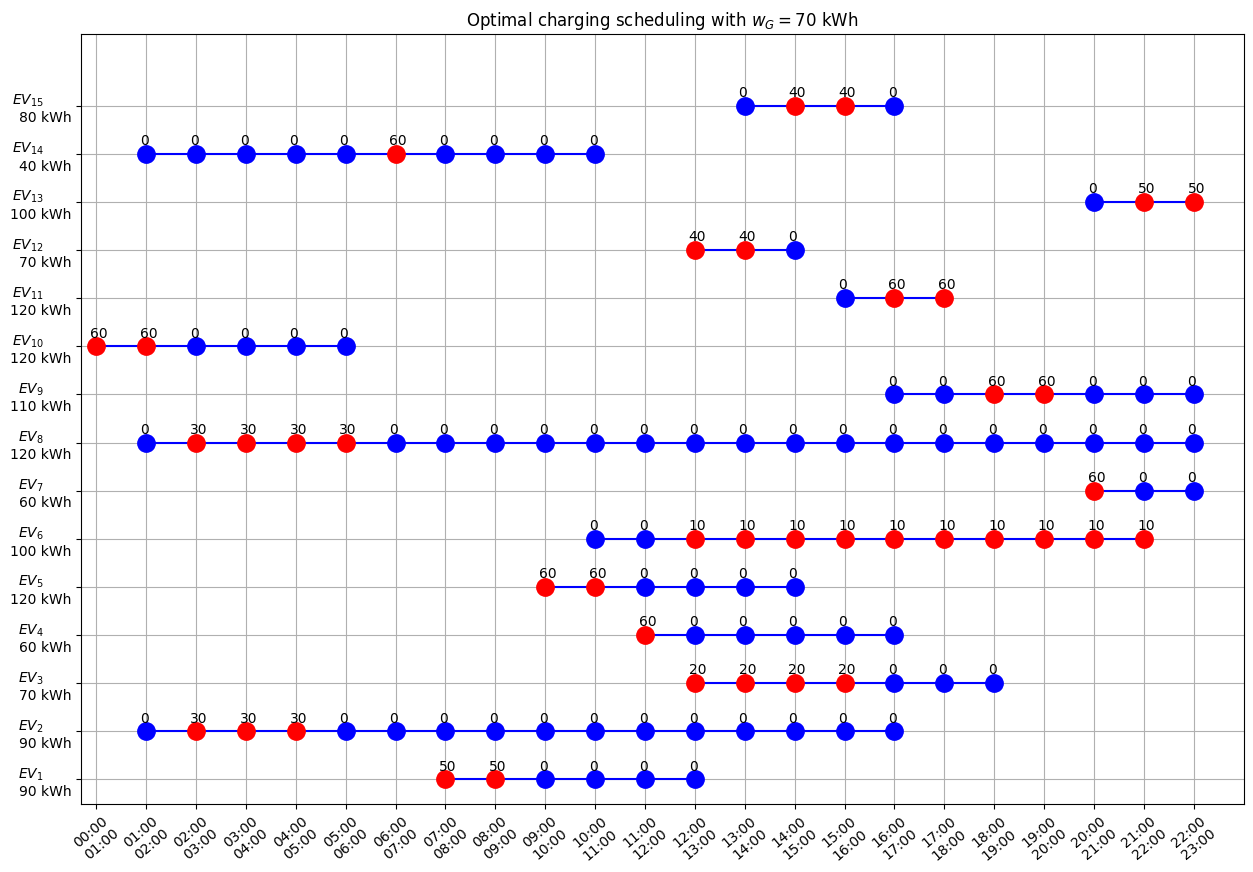

In [13]:
Instance = simulate_instance(
    n = 15, 
    min_arrival = "00:00",
    min_availability = "3:00",
    max_arrival = "23:59",
    min_required_energy = 30,
    step = 10,
    max_required_energy = 120,
    chargers = [10, 20, 30, 40, 50, 60],
    C = [10, 10, 10, 10, 10, 10],
    tho = 60
)

result = exact_solution(Instance, timelimit = 60)

if result["status"] == 1:
    plot_schedule(result["best_solution"], Instance, figsize = (15, 10))
else:
    print("No solution!")

# HSAGA

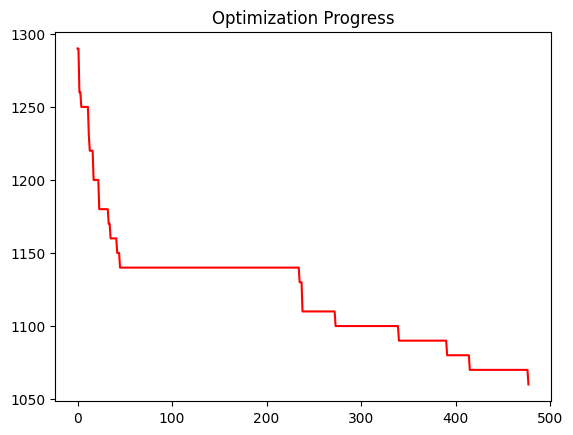

In [15]:
Instance = simulate_instance(
    n = 100, 
    min_arrival = "6:00",
    min_availability = "3:00",
    max_arrival = "23:00",
    min_required_energy = 30,
    step = 10,
    max_required_energy = 200,
    chargers = [20, 30, 40, 50, 60],
    C = [20, 10, 20, 10, 40],
    tho = 10
)

result = HSAGA(Instance, initial_temperature = 400, cooling_factor = 0.95, stopping_temperature = 1e-8, pop_size = 50, ps = 0.2, pm = 0.2, progress_report = True)

if result["status"] == 1:
    plt.figure()
    plt.plot(result["progress"], c = "red")
    plt.title("Optimization Progress")
    plt.show()
else:
    print("No solution!")